In [1]:
import os
import time
import argparse
import matplotlib.pyplot as plt
import numpy as np

from preprocessing import ReviewPreprocessor
from embeddings import EmbeddingsManager

from sentiments import (
    sentimentCache_init,
    sentiment_topicsFromSentence
)

embeddingManager: EmbeddingsManager = None

# Data are stored into a directory named after the topic and the seed
# For example, if seed is 1967 and the topic is "general", the directory will be "general/1967"
seed = 1967
file_path = "digital_music.jsonl"
topicGeneral = os.path.splitext(os.path.basename(file_path))[0]
if not os.path.exists(topicGeneral):
    os.makedirs(topicGeneral)
topicAndSeed = os.path.join(topicGeneral, str(seed))
if not os.path.exists(topicAndSeed):
    os.makedirs(topicAndSeed)
# Set cache files (shared amongst the modules)
sentiments_cache_file = os.path.join(topicAndSeed, f"{topicGeneral}_sentiments_cache.json")
embeddings_cache_file = os.path.join(topicGeneral, f"{topicGeneral}_embeddings_cache.pkl")
preprocessing_cache_file = os.path.join(topicGeneral, f"{topicGeneral}_preprocessing_cache.json")
# Set result file (csv format, containing original and adjusted ratings)
result_file = os.path.join(topicGeneral, f"{topicGeneral}_results.csv")

# Initialize embeddings cache
embeddingManager = EmbeddingsManager(
    embeddings_cache_file=embeddings_cache_file,
)

# Initialize sentiment cache
sentimentCache_init(sentiments_cache_file)
# Instantiate the Preprocessor (cache initialization is handled by the class)
preprocessor = ReviewPreprocessor(preprocessing_cache_file)
# ...existing code...

In [2]:

label_text = "text"
label_rating = "rating"

original_reviews: list[dict] = []
original_indices: set[int] = set()
preprocessed_reviews: list[str] = []
bagOfWords: list[str] = []


In [3]:
# Load a random sample of reviews from the file, preprocess them, then
# calculate the embeddings of the words found in the reviews.
# Load a random sample of reviews from the file, then process them.
original_reviews, original_indices = preprocessor.load_reviews(file_path, 1000, label_text, label_rating, seed)
print(f"\nLoaded {len(original_reviews)} reviews.")


Loaded 1000 reviews.


In [4]:
print("Preprocessing reviews...")
# Build a dict mapping review text to its rating, ensuring all keys are strings.
reviews_dict = {str(review["text"]): review["overall"] for review in original_reviews}

preprocessed_reviews, corrected_reviews = preprocessor.preprocess_reviews(reviews_dict)

Preprocessing reviews...
.

In [5]:
# split reviews into training and test sets
train_size = int(0.8 * len(corrected_reviews))
train_reviews = dict(list(preprocessed_reviews.items())[:train_size])
test_reviews = dict(list(preprocessed_reviews.items())[train_size:])
train_corrected_reviews = dict(list(corrected_reviews.items())[:train_size])
test_corrected_reviews = dict(list(corrected_reviews.items())[train_size:])


In [6]:

reviewTopicFile = os.path.join(topicAndSeed, f"{topicGeneral}_topics.json")

import json

listOfTopics: dict[str,str] = {}
# Loads the topics from the file if it exists
if os.path.exists(reviewTopicFile):
    with open(reviewTopicFile, "rt", encoding="utf-8") as f:
        json_data = f.read()
        if json_data != "":
            listOfTopics = json.loads(json_data)                    


In [7]:
from time import sleep
# Invoke the LLM to get the typical topics for the reviews
print("Invoking LLM to get typical topics...", end="")
for review in train_corrected_reviews.keys():  # Explicitly iterate over keys
    # Get the topics for each review
    if review in listOfTopics:
        continue
    while True:
        try:
            listOfTopics[review] = sentiment_topicsFromSentence(review)
            print(".", end="")
            break
        except Exception as e:
            sleep(0.2)
#            print(f"Error: {e}")
# Remove duplicates and empty strings
listOfTopics = {k: list(set(filter(None, v))) for k, v in listOfTopics.items()} 
print(" done.")
# Save the topics to the file
with open(reviewTopicFile, "wt", encoding="utf-8") as f:
    json.dump(listOfTopics, f, ensure_ascii=False, indent=4)


Invoking LLM to get typical topics... done.


In [8]:

bagOfWords = [term for topic in listOfTopics.values() for term in topic]
# Remove duplicates and empty strings   
bagOfWords = list(set(filter(None, bagOfWords)))
# correct and lemmatize
#bagOfWords, _ = preprocessor.preprocess_reviews(bagOfWords)
# Remove duplicates and empty strings   
bagOfWords = list(set(filter(None, bagOfWords)))
# add topics to embedding cache
embeddingManager.cacheTopicEmbeddings(bagOfWords)


702 unique topics
All embeddings already cached


In [9]:

# calculate sentence embeddings for the reviews
print("Calculating sentence embeddings...", end="")

from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

# Calculate the embeddings for the reviews
bagOfReviewsEmbeddings: dict[str, list[float]] = {}
embeddings = emb_model.encode(list(train_corrected_reviews.keys()), show_progress_bar=True, device="cpu")
# Store the embeddings in a dictionary, associating each review with its embedding
# This is not necessary, but it allows to check the embeddings for each review        
bagOfReviewsEmbeddings = {review: embedding for review, embedding in zip(train_corrected_reviews, embeddings)}

#del emb_model
#del embeddings

Calculating sentence embeddings...

Batches: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]


In [10]:

# reviewsEmbeddings associates the review with its embedding
# Now for each review embeddings, extract the three most relevant topics,
# using the semantic similarity.
topicsPerReview: dict[str, list[str]] = {}
for idx, (review, embeddings) in enumerate(bagOfReviewsEmbeddings.items()):
    # Get the topics for each review
    distances: dict[str, float] = {}
    for word in bagOfWords:
        # Calculate the semantic similarity between the review and the topic
        distances[word] = embeddingManager.getSimilarityDistance(embeddings, embeddingManager.getEmbedding(word))
    # Sort the distances and get the three most relevant topics
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    # Get the three most relevant topics    
    relevant_topics = [topic for topic, distance in sorted_distances if distance <= 0.6][:3]
    # Save the topics in the dictionary
    topicsPerReview[review] = relevant_topics
    del sorted_distances, distances, relevant_topics


In [11]:
managedTopics = len([review for review, topics in topicsPerReview.items() if topics])
print(managedTopics, "topics managed out of", len(topicsPerReview), "reviews")

604 topics managed out of 775 reviews


In [12]:
for review, topics in topicsPerReview.items():
    if not topics:
        continue
    print(f"Review: {review[:80]}")
    print(f"Topics: {', '.join(topics)}")
    print("")

Review: this is an excellent cd to listen to while making coffee or tea especially on a 
Topics: jazz

Review: metallica is the greatest fun metal band on the planet
Topics: metallica, metal, bands

Review: this exquisite disc featuring six provencals organs features several of the emin
Topics: instruments, organ, instrumentals

Review: all the songs i love on one cd can t be beat
Topics: songs, cd, song

Review: i bought this for a gift for my daughter she has been collecting the christmas s
Topics: village

Review: when it comes to recordings of the complete brahms symphonies we really have an 
Topics: brahms, symphonies, symphony

Review: loved this shamanic guided tour into my heart and into my wounds cd is not reall
Topics: tour

Review: babymetal rules and id is one of their best songs excellent addition to my be co
Topics: songs, babymetal

Review: came to house very fast
Topics: house, speed, arrival

Review: i am so happy with my purchase i got everything that was promised the

In [13]:
from sentiments import sentiment_parseScore
scores: dict[str, float] = {}
for review, topics in topicsPerReview.items():
    if not topics:
        continue
    scores[review] = sentiment_parseScore(review, 3, topics)

In [14]:
for review, score in scores.items():
    print(f"Review: {review[:80]}")
    print(f"Score: {score}")
    print("")

Review: this is an excellent cd to listen to while making coffee or tea especially on a 
Score: {'jazz': 1}

Review: metallica is the greatest fun metal band on the planet
Score: {'metallica': 1, 'metal': 1, 'bands': 1}

Review: this exquisite disc featuring six provencals organs features several of the emin
Score: {'instruments': 1, 'organ': 1, 'instrumentals': 1}

Review: all the songs i love on one cd can t be beat
Score: {'songs': 1, 'cd': 1, 'song': 1}

Review: i bought this for a gift for my daughter she has been collecting the christmas s
Score: {'village': 1}

Review: when it comes to recordings of the complete brahms symphonies we really have an 
Score: {'brahms': 0, 'symphonies': 0, 'symphony': 0}

Review: loved this shamanic guided tour into my heart and into my wounds cd is not reall
Score: {'tour': 1}

Review: babymetal rules and id is one of their best songs excellent addition to my be co
Score: {'songs': 1, 'babymetal': 1}

Review: came to house very fast
Score: {'house'

In [15]:
# Now we have what we need to do the analysis.
# First, calculate the adjusted rating for each review from
# the original rating and the scores dictionary.
adjusted_ratings: dict[str, float] = {}
for review in train_corrected_reviews.keys():
    originalScore: float = train_corrected_reviews[review]
    adjustedScore: float = originalScore
    if review not in scores:
        continue
    for score in scores[review].values():
        nscore: float = float(score)
        adjustedScore += nscore/2.0
    adjusted_ratings[review] = adjustedScore


for review, adjusted_rating in adjusted_ratings.items():
    print(f"Review: {review[:80]}")
    print(f"Adjusted rating: {adjusted_rating}")
    print("")

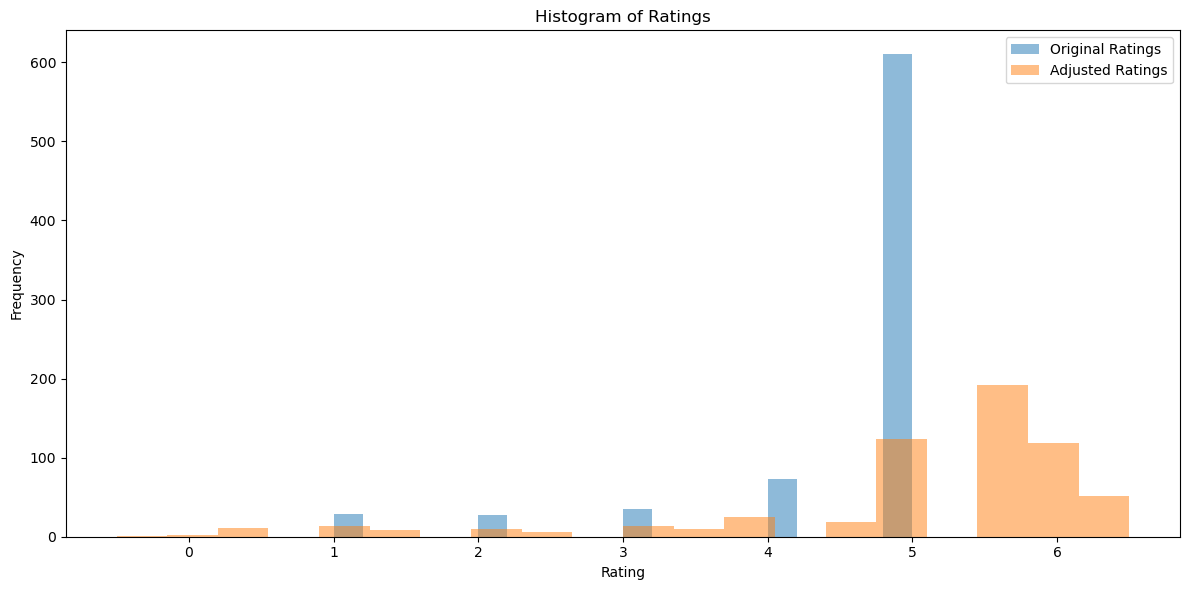

In [16]:
# Now we can show the results as two histograms on the same figure
plt.figure(figsize=(12, 6))
plt.hist(list(train_corrected_reviews.values()), bins=20, alpha=0.5, label='Original Ratings')
plt.hist(list(adjusted_ratings.values()), bins=20, alpha=0.5, label='Adjusted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(topicAndSeed, f"{topicGeneral}_histograms.png"))
plt.show()

In [18]:
import csv
with open(result_file, "wt", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    # Write the header
    writer.writerow(["review[40]", "original_rating", "adjusted_rating", "topics", "set", "review"])
    # Write the data
    for review, original in zip(train_corrected_reviews, train_reviews):
        originalScore: float = original["score"]
        adjustedScore: float = adjusted_ratings.get(review, 0.0)
        topics: str = ", ".join(topicsPerReview.get(review, []))
        writer.writerow([review[:40], originalScore, adjustedScore, topics, "train", review])


TypeError: string indices must be integers, not 'str'

In [21]:
# Now the idea is to use the topics extracted with the training set and 
# see how they perform on the test set.
# To do so, we need to calculate the embeddings for the test set and then
# calculate the scores for each review in the test set.

# Calculate the embeddings for the reviews
emb_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = emb_model.encode(list(test_corrected_reviews.keys()), show_progress_bar=True, device="cpu")
# Store the embeddings in a dictionary, associating each review with its embedding

# now get the embeddings for the test set
bagOfReviewsEmbeddings = {review: embedding for review, embedding in zip(test_corrected_reviews, embeddings)}

del emb_model
del embeddings

Batches: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


In [22]:
# Now for each review embeddings, extract the three most relevant topics,
# using the semantic similarity.
# But note: we will use the topics from the training set, not the test set!
topicsPerReview: dict[str, list[str]] = {}
for idx, (review, embeddings) in enumerate(bagOfReviewsEmbeddings.items()):
    # Get the topics for each review
    distances: dict[str, float] = {}
    for word in bagOfWords:
        # Calculate the semantic similarity between the review and the topic
        distances[word] = embeddingManager.getSimilarityDistance(embeddings, embeddingManager.getEmbedding(word))
    # Sort the distances and get the three most relevant topics
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    # Get the three most relevant topics    
    relevant_topics = [topic for topic, distance in sorted_distances if distance <= 0.6][:3]
    # Save the topics in the dictionary
    topicsPerReview[review] = relevant_topics
    del sorted_distances, distances, relevant_topics
managedTopics = len([review for review, topics in topicsPerReview.items() if topics])
print(managedTopics, "topics managed out of", len(topicsPerReview), "reviews")

143 topics managed out of 194 reviews


In [23]:
# Now we can calculate the scores for each review in the test set.
scores: dict[str, float] = {}
for review, topics in topicsPerReview.items():
    if not topics:
        continue
    scores[review] = sentiment_parseScore(review, 3, topics)


In [25]:
# Calculate the adjusted rating for each review from
# the original rating and the scores dictionary.
adjusted_ratings: dict[str, float] = {}
for review, original in zip(test_corrected_reviews, test_reviews):
    originalScore: float = original["score"]
    adjustedScore: float = originalScore
    if review not in scores:
        continue
    for score in scores[review].values():
        nscore: float = float(score)
        adjustedScore += nscore/2.0
    adjusted_ratings[review] = adjustedScore

TypeError: string indices must be integers, not 'str'

In [ ]:
# ... and finally do a fancy plot of the results
plt.figure(figsize=(12, 6))
plt.hist([review["overall"] for review in test_reviews], bins=20, alpha=0.5, label='Original Ratings')
plt.hist(list(adjusted_ratings.values()), bins=20, alpha=0.5, label='Adjusted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(topicAndSeed, f"{topicGeneral}_histograms.png"))
plt.show()

In [ ]:
# Not bad, it seems!
# Now we can save the results to a CSV file. We want to store data in this format:
# review, original rating, adjusted rating, topics, if it was training or test set
with open(result_file, "wt", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    for review, original in zip(test_corrected_reviews, test_reviews):
        originalScore: float = original["overall"]
        adjustedScore: float = adjusted_ratings.get(review, 0.0)
        topics: str = ", ".join(topicsPerReview.get(review, []))
        writer.writerow([review[:40], originalScore, adjustedScore, topics, "test", review])
